# Full Face Landmarks Detection (Highly Improved)
> “What this algorithm does to the landmarks, is the same thing that a dentist/orthodontist does to his patient's teeth”

<br>
<video loop autoplay muted height="480" src="https://download1589.mediafire.com/e06n9v58jnhg/gnl6u12mllwrp40/hair.mp4
"></video><br>
<br>
<h3>What's improved?</h3>

<ol>
    <li>
        <b>Better Quality - Method 1:</b><br>
by using the best of the shape_predictor_68_landmarks (higher quality BUT fewer landmarks) and shape_predictor_81_landmarks (more landmarks -full face- BUT lower quality) we got a high quality full face landmarks detection.<br>
    </li>
    <li>
        <b>Better Quality - Method 2:</b><br>
the accuracy of shape_predictor_81_landmarks is <b>improved by repositioning forehead landmarks coordinates to a more accurate position.</b><br>
    </li>
</ol>



<h3>How is it improved</h3>
<ol>
    <li>
        <b>Method 1</b>:<br>
using both 68 and 81 landmarks predictors is done by partial selection, select the 68 points from the 68 landmarks shape predictor and the last 13 points from the 81 landmarks shape predictor<br>
    </li>
    <li>
        <b>Method 2</b>:<br>
moving the forehead landmarks is improved by heuristically clustering skin colors and giving a range for each cluster, then moving every point individually upward by a specified step size (a number in pixels), until the color underneath the landmarks is out of the skin color range -which means we reached the edge between forehead & hair-, there, is the best position for a landmark on the forehead<br>
    </li>
    <li>
        <b>How to determine the range of the skin color?</b>: <br>
take a slice from the nose (the most part that's not affected by shadows/lights issues), then calculate the average of pixels colors, then discover which cluster is this skin color, finally set range based on that cluster. <br>
    </li>
    <li>
        <h3>What if the forehead is too clear (bald man)?:</h3>
       <video loop autoplay muted height="480" src="https://download1494.mediafire.com/uxnyyyfn035g/s23azhnqfu6ci35/bald.mp4
    "></video><br>
    </li>
    <li>
        <h3>What if the forehead isn't clear, (hair covers it)?:</h3>
   <video loop="true" muted autoplay height="480" src="https://download1488.mediafire.com/h3rqg2fr2lkg/ygkrqsjpot665c3/haircut.mp4"></video>
    </li>
</ol>



In [1]:
! pip install imutils

import os
import math
import cv2
import dlib
import numpy as np
from imutils import face_utils
import matplotlib.pyplot as plt

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=ce992e6cb9e2279b66c3fcd5716de1dd29e277efa82fbad7dde98c3e07daa538
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
# Define mathematics functions

def slope(point1, point2, absolute=False):
    x1,y1 = point1
    x2,y2 = point2
    deltaX = x2-x1
    deltaY = y2-y1
    if deltaX == 0:
        return "inf"
    slope = deltaY / deltaX
    if absolute:
        slope = abs(slope)
    return round(slope,3)

In [3]:
# Define helper functions

def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            filenames.append(filename)
    return images, filenames


In [4]:
# Build 'computer vision' functions

predictor68 = dlib.shape_predictor('../input/shape-predictor-68-face-landmarks/shape_predictor_68_face_landmarks.dat')
predictor81 = dlib.shape_predictor('../input/shape-predictor81/shape_predictor_81_face_landmarks.dat')

# Function to determine the color range allowed to move landmarks points through image
def getAllowedColorRange(avgSkinColor):
    # Dark skin
    if (avgSkinColor < 100):
        colorRange = (avgSkinColor-35, avgSkinColor+50)
    # Somehow dark skin
    elif(avgSkinColor <= 130): 
        colorRange = (avgSkinColor-30, avgSkinColor+30)
    # Normal skin color (tends to dark)
    elif(avgSkinColor <= 160):
        colorRange = (avgSkinColor-40, avgSkinColor+40) 
    # Normal skin color 
    elif(avgSkinColor < 180):
        colorRange = (avgSkinColor-50, avgSkinColor+50)
    # Normal skin color (tends to white)
    elif(avgSkinColor < 210):
        colorRange = (avgSkinColor-50, avgSkinColor+30) 
    # white skin color
    elif (avgSkinColor < 230):
        colorRange = (avgSkinColor-40, avgSkinColor+20)
    # Abnormal white skin color
    else:
        colorRange = (avgSkinColor-30, avgSkinColor+15)
    return colorRange

# Function to move landmarks points, based on skincolor
def moveUp(grayscale_image, point, avgSkinColor, foreheadHeight):
    # Get color range & current color where the point is located in image
    steps = 5
    portionOfOriginalPointY = 0.275
    originalPoint = np.copy(point)
    colorRange = getAllowedColorRange(avgSkinColor)
    currentPixelColor = grayscale_image.item(point[1],point[0])
    
    # move the landmark point up until a strong change of color happen (outside color range)
    while currentPixelColor > colorRange[0] and currentPixelColor < colorRange[1]:
        
        # If point is going out of image boundary
        if point[1] < 0:
            # Get back to original point location, with a little bit higher
            point[1] = originalPoint[1] - (originalPoint[1] * portionOfOriginalPointY)
            break
            
        # move up (N steps) pixels & get the color
        point[1] = point[1] - steps
        
        currentPixelColor = grayscale_image.item(point[1],point[0])
        
    # if the pixel is moved too high than expected (3/4 forehead height): keep close to original
    if abs( originalPoint[1] - point[1] ) > ( foreheadHeight * 0.75 ):
        point[1] = originalPoint[1] - (originalPoint[1] * portionOfOriginalPointY)
    return point

# Function to detect if the forehead is clear or covered with hair (it corrupts the enhancement of landmarks points)
def clearForehead(forehead, avgSkinColor):
    clarityThreshold = 85
    colorRange = getAllowedColorRange(avgSkinColor)
    
    # Check if most of the forehead is the same as skin color
    regionOK = np.logical_and(forehead > colorRange[0] , forehead < colorRange[1])
    try:
        percentage = (np.count_nonzero(regionOK) / forehead.size) * 100
    except:
        return False
    isClear = True if percentage >= clarityThreshold else False
    return isClear


# Function to perform facial landmark detection on the whole face
def facial_landmarks(image, eyeOnlyMode=False, allowEnhancement=False):
    # ARGUMENTS:
    # - eyeOnlyMode: detect & return eye landmarks, used to align face
    # - allowEnhancement: allow improvement (landmarks repositioning)
    
    # Return:
    # - NumPy array of coordinates of landmarks
    
    # Use dlib 68 & 81 to predict landmarks points coordinates
    detector = dlib.get_frontal_face_detector()
    global predictor68
    global predictor81
    
    # Grayscale image
    try:
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except:
        grayscale_image = image
    
    # array of rectangles surrounding faces detected
    rectangles = detector(grayscale_image, 1)

    # If at least one face is detected   
    if len(rectangles) > 0:
        # Get 68 landmark points
        faceLandmarks = predictor68(grayscale_image, rectangles[0])
        faceLandmarks = face_utils.shape_to_np(faceLandmarks)
        
        if eyeOnlyMode:
            # Return eye points to perform a calculated rotation
            return np.array([faceLandmarks[39], faceLandmarks[42]])
        
        # Get 81 landmark points
        foreheadLandmarks = predictor81(grayscale_image, rectangles[0])
        foreheadLandmarks = face_utils.shape_to_np(foreheadLandmarks)
        
        # Get 68 point from -68- predictor (higher accuracy) + forehead from -81- predictor
        fullFacePoints = np.concatenate((faceLandmarks, foreheadLandmarks[68:]))
        
        # Get forehead region & height to perform simple improvement
        x,y,x2,y2 = (fullFacePoints[69,0]-10, fullFacePoints[68,1], fullFacePoints[80,0]+10, fullFacePoints[23, 1])
        foreheadRegion = grayscale_image[y:y2,x:x2]
        foreheadHeight = foreheadRegion.shape[0]
        
        if allowEnhancement:
            # Perform progressive quality improvement
            # Get nose region to get average skin color
            x,y,x2,y2 = (fullFacePoints[28,0]-5, fullFacePoints[28,1], fullFacePoints[28,0]+5, fullFacePoints[30,1])
            noseRegion = grayscale_image[y:y2, x:x2]
            avgSkinColor = np.average(noseRegion[:,:])
            
            # Check if forehead is clear -> perform heuristic based enhancement
            forehead_is_clear = clearForehead(foreheadRegion, avgSkinColor)
            originalPoints = fullFacePoints[[69,70,71,73,80]]
            
            if forehead_is_clear:
                avgSkinColor = np.average(foreheadRegion)
                
                # Modify some points for more accuracy
                # Point[68] will be center between lower-lip & chin
                distance = int((fullFacePoints[8,1]-fullFacePoints[57,1]) / 2)
                fullFacePoints[68] = np.array([fullFacePoints[8,0], fullFacePoints[8,1]-distance])
                
                # Enhance points locations
                enhancedPoints = np.array([moveUp(grayscale_image, orgPoint, avgSkinColor, foreheadHeight) for orgPoint in originalPoints])

                # Assign original points to enhanced points (some maybe the same)
                fullFacePoints[[69,70,71,73,80]] = enhancedPoints  
                
                # Adjust points to fix any corruptions
                fullFacePoints[[69,70,71,73,80]] = adjustPoints(enhancedPoints, fullFacePoints[76], fullFacePoints[79])

                #Prepare point[72] for center of forehead
                distance = (fullFacePoints[22,0] - fullFacePoints[21,0]) / 2
                distanceY = (fullFacePoints[21,1] - fullFacePoints[71,1]) / 2
                fullFacePoints[72] = np.array([fullFacePoints[21,0] + distance, fullFacePoints[21,1]-distanceY])
                
                # Point[74] sometimes have a fixed corruption, this line helps :)
                fullFacePoints[74,0] -= foreheadHeight * 0.1 # Arbitery heurestic
                
            else:
                # If forehead isn't clear -> fix points with very simple heuristics
                fullFacePoints[70,1] -= foreheadHeight * 0.2
                fullFacePoints[71,1] -= foreheadHeight * 0.3
                fullFacePoints[80,1] -= foreheadHeight * 0.2
    
        else:
            # If Enhancement is False -> do the simple enhancement, better quality + low performance :)
#             fullFacePoints[70,1] -= foreheadHeight * 0.2
#             fullFacePoints[71,1] -= foreheadHeight * 0.3
#             fullFacePoints[80,1] -= foreheadHeight * 0.2
            pass
        
        return fullFacePoints
    # No faces found
    else:
        return None

# Function to adjust landmarks points of the forehead 
# and fix corruptions of improvement (such as the bald man case)
def adjustPoints(points, leftSidePoint, rightSidePoint):    
    # Use shape_predictor_81 as a reference for points indexes to fix:
    # points = [69,70,71,73,80]
    # LeftSidePoint = 76  |  rightSidePoint = 79
    
    slopes = []
    slopeThreshold = 0.4 # slope > 0.4 = corruption -> fix
    totalSlopeThreshold = 1 # sum of slopes > 1 = corruption -> fix
    leftPoint = points[0]
    rightPoint = points[3]
    criticalLeftPoint = points[1]
    criticalRightPoint = points[4]
    
    # if any point is higher than a (accurate located point) -> fix
    if leftPoint[1] < criticalLeftPoint[1] :
        points[0,1] = np.average([criticalLeftPoint[1], leftSidePoint[1]])
    if rightPoint[1] < criticalRightPoint[1]:
        points[3,1] = np.average([criticalRightPoint[1], rightSidePoint[1]])
    
    # Collect some slopes of the usually corrupted points
    slopes.append(slope(points[1], points[2], True))
    slopes.append(slope(points[2], points[4], True))
    
    # Calculate slope differences & sum
    difference = abs(np.diff(slopes))
    _sum = np.sum(slopes)
    
    # If calculation results (either) too high = corruption -> fix
    if difference > slopeThreshold:
        issueIndex = np.argmax(slopes)
        if issueIndex == 0:
            points[1,1] = max(points[4,1], points[2,1])
        else:
            points[4,1] = max(points[1,1], points[2,1])
            
    if _sum > totalSlopeThreshold:
        points[1,1] = np.average(points[[4,2], 1])
        points[4,1] = np.average(points[[1,2], 1])
        points[2,1] = np.average(points[[4,1], 1])  
        
    return points

# Function to rotate image to align the face
def align_face(image, eyePoints):
    # Get left eye & right eye coordinates
    leftEyeX,leftEyeY = eyePoints[0]
    rightEyeX, rightEyeY = eyePoints[1]

    # Calculate angle of rotation & origin point
    angle = math.atan( (leftEyeY - rightEyeY) / (leftEyeX - rightEyeX) ) * (180/math.pi)
    origin_point = tuple(np.array(image.shape[1::-1]) / 2)

    # Rotate using rotation matrix
    rot_mat = cv2.getRotationMatrix2D(origin_point, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result


# Function to draw points on facial features
def drawPoints(image, points, pointColor=(255,255,255), lineColor=(255,255,255), pointThickness=None, lineThickness=1):
    if pointThickness is None:
        pointThickness = round((7/1200) * image.shape[1])
    imgcopy = image.copy()
    for i in points:
        x,y = i
        imgcopy = cv2.circle(imgcopy, (x,y), radius=0, color=pointColor, thickness=pointThickness)
    return imgcopy


def main():
    # Capture all images in current folder & their names
    images, filesnames = load_images_from_folder('../input/facessamples2')
    
    # Detect & Visualize each image
    for originalImage in images:
        originalImage = cv2.cvtColor(originalImage,cv2.COLOR_BGR2RGB)
        
        eyes_landmarks = facial_landmarks(originalImage, eyeOnlyMode=True)
        
        if eyes_landmarks is not None:
            # Align face
            face_aligned = align_face(originalImage, eyes_landmarks)
            
            # Detect landmarks (NO improve)
            landmarks_no_improve = facial_landmarks(face_aligned,
                                                    allowEnhancement=False)
            
            # Draw landmarks (not improved)
            image_no_improve = drawPoints(face_aligned, landmarks_no_improve)
            
            
            # Improve landmarks after the face is aligned
            landmarks_improved = facial_landmarks(face_aligned,
                                                  allowEnhancement=True
                                                 )
            
            # Draw landmarks (not improved)
            image_improved = drawPoints(face_aligned, landmarks_improved)
            

            f, axarr = plt.subplots(1,2, figsize=(16,16))
            axarr[0].imshow(image_no_improve)
            axarr[0].set_axis_off()
            axarr[0].set_title("Before Improve")
            
            axarr[1].imshow(image_improved)
            axarr[1].set_axis_off()
            axarr[1].set_title("After Improve")
            
            plt.show()
            print()
            print()

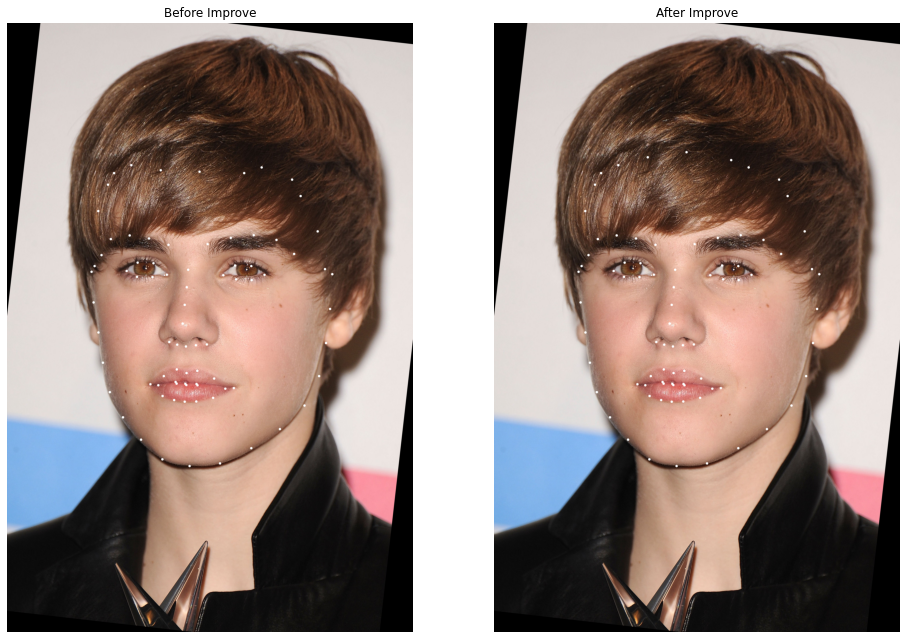

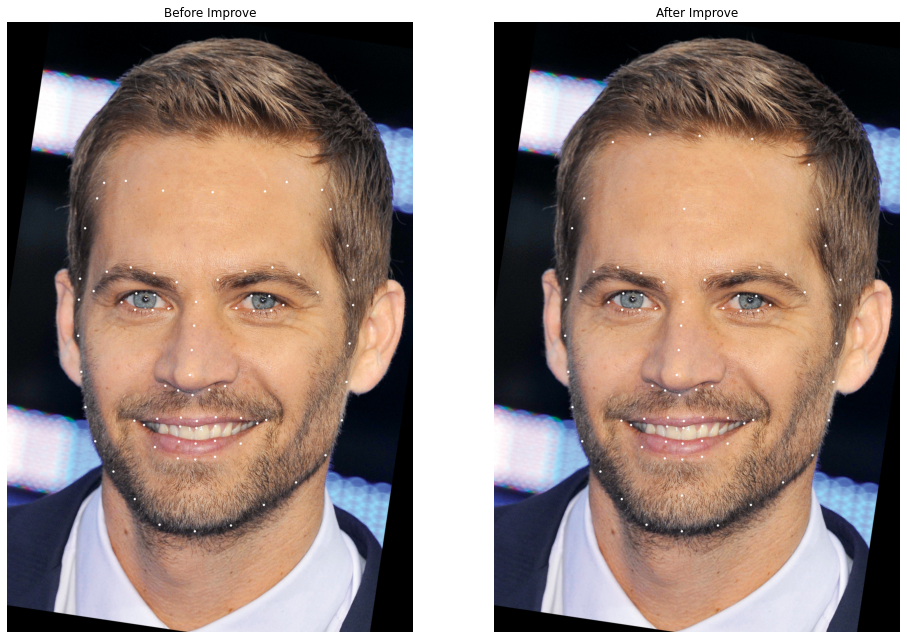

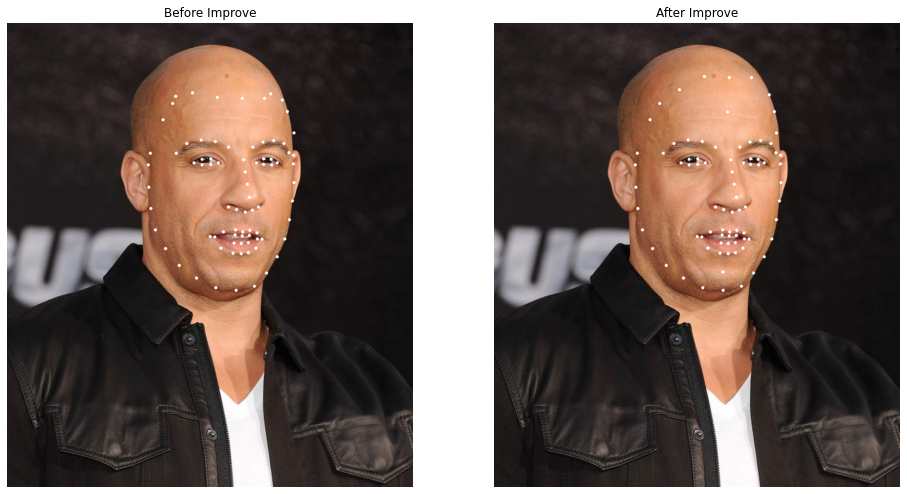

In [5]:
main()